Jonathan McEntee - September 9th 2018

Things that need to be done:
 - Find two "interesting" datasets. Aka, datasets that don't train exactly the same accuracy
 - Explain the cars dataset classification problem and why you feel its interesting
 - Write an introduction to the second dataset (digits?)
 - Fix the cross_validation v training graphs
 - Measure the time it takes to run each algorithm, also under different circumstances
 - Perform analysis on datasets/algorithms including:
  - how fast each model ran
  - which algorithm performed best
  - how do you define best?
  - analysis of why you chose different hyperparameter options

In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import graphviz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

# Blood Transfusion Data Set

The first data set I train the models on come from the donor database of a blood transfusion center in Taiwan. The database includes data used to construct features the models can train on:

- recency is the number of months since the donor last made a donation
- frequency is the total number of donations they've made
- monetary is the total blood they've donated in c.c. (this has a correlation of 1 with frequency)
- time is the number of months since their first donation

Finally there is a binary variable indicating if the donor donated blood in March 2007. We were asked to pick two interesting data sets for this assignment. I find the blood transfusion set interesting because through it we can attempt to predict the turnout of donors. Turnout prediction is a key problem in a number of fields, and one I'm eager to work on.

In [2]:
blood_data = pd.read_csv('transfusions.csv')
blood_data["donated_blood"] = blood_data.donated_blood.apply(lambda x : 'Yes' if x is 1 else 'No')
blood_data.head()

,recency,frequency,monetary,time,donated_blood
0,2,50,12500,98,Yes
1,0,13,3250,28,Yes
2,1,16,4000,35,Yes
3,2,20,5000,45,Yes
4,1,24,6000,77,No


In [3]:
blood_data.donated_blood.value_counts()

No     570
Yes    178
Name: donated_blood, dtype: int64

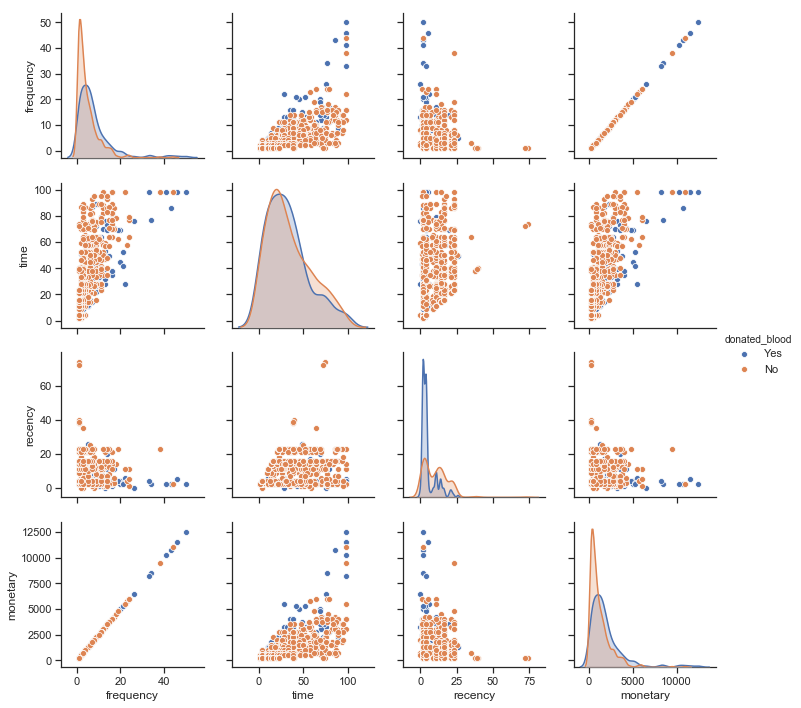

In [4]:
sns.set(style='ticks')
sns.pairplot(blood_data, hue='donated_blood', vars=['frequency', 'time', 'recency', 'monetary'])

In [5]:
y = blood_data["donated_blood"]
X = blood_data.drop(["donated_blood", "monetary"], axis=1)

There are a lot of duplicate values within the data causing noise

In [6]:
duplicates = X[X.duplicated()]
duplicates.sort_values(by=list(duplicates.columns)).head()

,recency,frequency,time
154,2,1,2
155,2,1,2
156,2,1,2
157,2,1,2
158,2,1,2


In [7]:
non_duplicates = y.index.difference(duplicates.index)
y_nd = y.iloc[non_duplicates]
X_nd = X.iloc[non_duplicates]

In [8]:
y_nd.value_counts()

No     371
Yes    131
Name: donated_blood, dtype: int64

In [9]:
y_train_nd, y_test_nd = train_test_split(y_nd, test_size=0.1, stratify=y_nd, random_state=42)
X_train_nd, X_test_nd = train_test_split(X_nd, test_size=0.1, stratify=y_nd, random_state=42)

## Create Test and Training Sets

10% of the data was withheld and put into a test set. The remaining 90% was placed in the training set to be fed into our models. The entire dataset contains 748 samples including 570 positive samples (people who donated blood in March 2007) and 178 negative samples. As the classes are somewhat unbalanced, I decided to stratify the test train split.

In [10]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

## Functions

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding tfdrain/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                          n_jobs=1, param_name=None, alternative_x_axis=None,
                          param_range=np.linspace(1, 100, 10), xlab=None, log=False):
    
    x_axis = alternative_x_axis if alternative_x_axis is not None else param_range
    xlab = "Parameter Setting" if xlab is None else xlab
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel("Score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, param_name=param_name, param_range=param_range)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    if log:
        plt.xscale("log")
    
    plt.fill_between(x_axis, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(x_axis, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(x_axis, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(x_axis, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Using a Decision Tree Classifier

The decision tree, like all the other models I trained for this paper, was taken from the scikit-learn package available for python. The decision tree here is based on the CART algorithm. Rather than entropy, a gini score is used to choose where to split the data. The decision tree can train on both categorical and numerical features.

I began my analysis by performing a grid search over the hyperparameters max_depth and min_samples_split to see which produced the highest cross-validation score (10 folds). The decision tree will not split the data more than max_depth-times down any individual branch. min_samples_split is the mininum number of samples needed in a node for it to be split into a new branch. Setting these parameters is equivalent to pre-pruning the tree. The values max_depth = 3 and min_samples_split = 140 appear to produce the highest cross-validation score, so we'll use those as a starting point.

In [25]:
?plt.fill_between

In [8]:
parameters = {
    'max_depth' : list(range(1, 30, 2)),
    'min_samples_split' : list(range(20, 1000, 10))
}

decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 3, 'min_samples_split': 140}

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

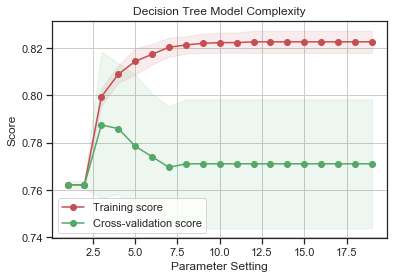

In [9]:
# built in validation curve
clf = DecisionTreeClassifier(min_samples_split=40)
plot_validation_curve(estimator=clf, title="Decision Tree Model Complexity",
                      X=X_train, y=y_train, param_name='max_depth',
                      param_range=range(1, 20), cv=10)

As the max_depth of the decision tree increases, the training score moves asymptotically towards about 82% accuracy. Meanwhile the cross-validation score peaks at 3 or 4 depth and then plummets until it reaches 8 depth. From there it flatlines at about 77% accuracy. From this graph it's apparent that the algorithm is able to construct trees that better fit the training data as max_depth grows, but those increasingly elaborate trees do not generalize well. Which is exactly what we expect to see.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

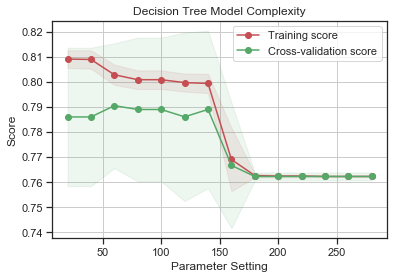

In [23]:
clf = DecisionTreeClassifier(max_depth=4)
plot_validation_curve(estimator=clf, title="Decision Tree Model Complexity",
                      X=X_train, y=y_train, param_name='min_samples_split',
                      param_range=range(20, 300, 20), cv=10)

The min_samples_split parameter on the other hand, seems to perform roughly the same for any setting below 150 samples, after which both training and cross-validation scores plummet. It seems the model needs the flexibility to split sample sets as small as 150 to properly fit the model.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

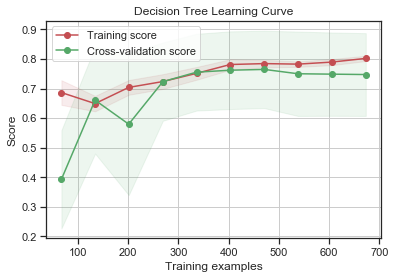

In [23]:
# the built in learning curve
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=60)
plot_learning_curve(estimator=clf, title="Decision Tree Learning Curve", X=X, y=y, cv=10)

The learning curve for the decision tree shows both the training and cross-validation scores steadily increasing as more samples are made available. The training curve grow at roughly the same rate, showing that the gains made by having more training data are generalizing reasonably well, but the variance of the cross-validation score also remains high.

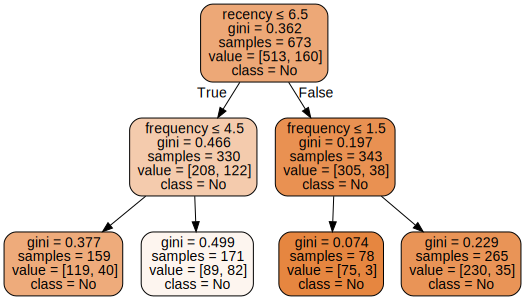

In [13]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=40)
clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, out_file=None,  
                         feature_names=X.columns,
                         class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True)  

graphviz.Source(dot_data)

Out of curiousity, I trained a small decision tree (max_depth = 2) on the training data and constructed a graph of it using graphviz. This allows us to see how the decision tree is dividing the data. We can see that donors who have donated recently (less than 7 months before) had a high probability (~89%) of donating blood in March 2007. If they have furthermore, not made more than a single donation in the past, that probability rises to 96%.

In [14]:
clf.score(X_test, y_test)

0.76

## Using K Nearest Neighbors

In [24]:
parameters = {
    'n_neighbors' : list(range(1, 30)),
    'weights' : ['uniform', 'distance'],
    "p" : [1, 2]
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}

Our grid search suggests that the best parameters for our model are setting n_neighbors = 16, p = 2 (euclidean distance), and weights = 'uniform' (no distance weighting). We'll use these parameters as a starting point

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

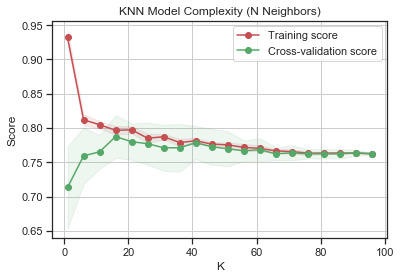

In [29]:
clf = KNeighborsClassifier(p=2)
plot_validation_curve(estimator=clf, title="KNN Model Complexity (N Neighbors)", X=X_train, y=y_train,
                      param_name='n_neighbors', param_range=range(1, 100, 5), cv=10, xlab="K")

As we increase K the training score falls and the cross-validation score rises, until K reaches about 40, at which point cross-validation begins to fall as well. As K increases so does the bias of the model, and ultimately the scores converge. This plot suggests our grid search chose an appropriate value for k_neighbors.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

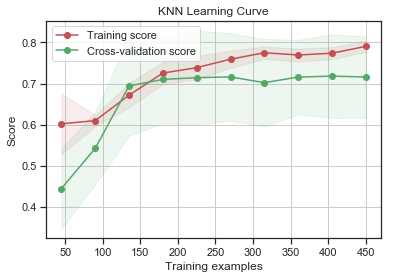

In [31]:
# the built in learning curve
clf = KNeighborsClassifier(p=2, n_neighbors=15)
plot_learning_curve(estimator=clf, title="KNN Learning Curve", X=X, y=y, cv=10)

The learning curve is similar to the decision tree. The cross-validation score rises with the training score, which shows that model is not overfitting, but the cross-validation score's variance is high.

In [34]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7866666666666666

## Using AdaBoost

In [30]:
parameters = {
    'n_estimators' : list(range(20, 80)),
    'learning_rate' : [10**x for x in range(-1, 2)],
}

ada_booster = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=70))
clf = GridSearchCV(ada_booster, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 29}

Running a gridsearch for the AdaBoost model gives us learning_rate = 0.1 and n_estimators = 29 as optimal parameters. We set our decision tree parameters at max_depth = 4, min_samples_split = 40, the same parameters we chose for our final model before.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

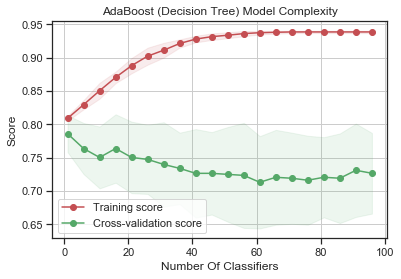

In [46]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=40), learning_rate=1)
plot_validation_curve(estimator=clf, title="AdaBoost (Decision Tree) Model Complexity",
                      X=X_train, y=y_train, param_name='n_estimators', param_range=range(1, 100, 5),
                      cv=10, xlab="Number Of Classifiers")

Surprisingly a single decision tree appears to perform better than multiple boosted trees. As the number of estimators increases, the training score rises, but the cross-validation score falls. This signals that the model overfits with more estimators.

A brief aside: the AdaBoost model should be able to perfectly fit the training data with enough estimators. So why does it asymptotically approach 93%? It turns out that about 30% of the dataset have features that are exactly the same, but some of these samples with identical features will have a different classification. As such, there are "two versions of the truth" on a large percentage of the data.

I thought this problematic data might be behind the AdaBoost model performing more poorly than the decision tree, but removing the data and retraining the model produces a similar result.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

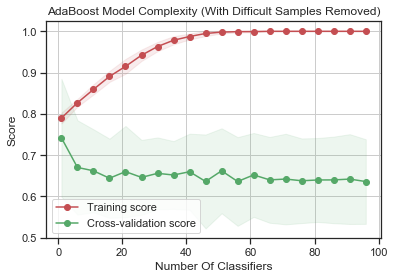

In [44]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4, min_samples_split=40), learning_rate=1)
plot_validation_curve(estimator=clf, title="AdaBoost Model Complexity (With Difficult Samples Removed)",
                      X=X_nd, y=y_nd, param_name='n_estimators', param_range=range(1, 100, 5),
                      cv=10, xlab="Number Of Classifiers")

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

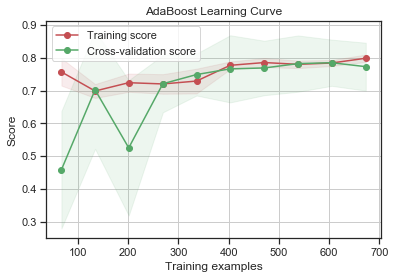

In [65]:
# the built in learning curve
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20),
                         learning_rate=1, n_estimators=3)
plot_learning_curve(estimator=clf, title="AdaBoost Learning Curve", X=X, y=y, cv=10)

The learning curve shows the training score and cross validation score converge within 300 samples. By 500 samples the scores seem to have stopped rising.

In [66]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7733333333333333

## Using a Neural Net

In [67]:
parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)],
    'max_iter' : range(200, 500, 100)
}

# 'max_iter' : range(200, 500, 50),

mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'hidden_layer_sizes': (80, 80, 80), 'max_iter': 300}

Our grid search over the neural net algorithm gives us the starting parameters of max_iter = 300 (max iterations) and hidden_layer_sizes = (80, 80, 80) (three hidden layers with 80 nodes each).

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

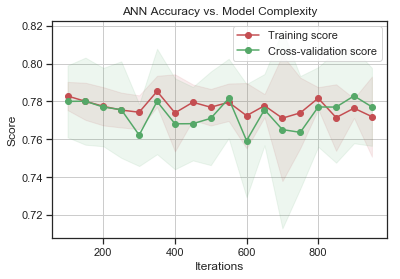

In [50]:
clf = MLPClassifier(hidden_layer_sizes=(80, 80, 80), tol=1e-1000)
plot_validation_curve(estimator=clf, title="ANN Accuracy vs. Model Complexity", X=X_train, y=y_train,
                      param_name='max_iter', param_range=range(100, 1000, 50), cv=10,
                      xlab="Iterations")

However, when we scan over different values of max_iter and the scores it produces, we find no apparent rising or falling trend.

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

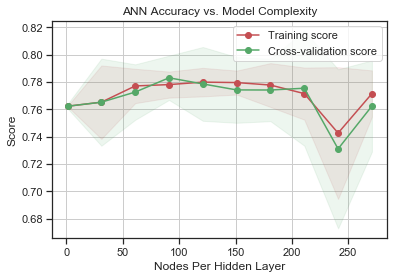

In [45]:
clf = MLPClassifier(max_iter=650)
plot_validation_curve(estimator=clf, title="ANN Accuracy vs. Model Complexity", X=X_train, y=y_train,
                      param_name='hidden_layer_sizes',
                      param_range=[tuple([x] * 3) for x in range(1, 300, 30)],
                      alternative_x_axis=range(1, 300, 30),
                      cv=10, xlab="Nodes Per Hidden Layer")

I want to try different layer sizes for my neural net, so I set the NN to have 3 hidden layers, and set the layers per node to different values to see how the scoring changed. But again, there no apparent relationship between more nodes and accuracy. I decided to stick with the parameters given by the grid search.

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

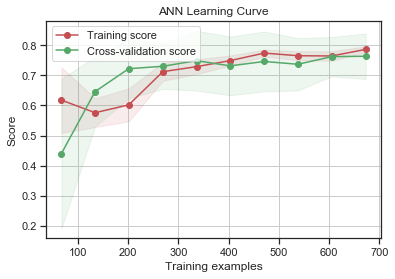

In [92]:
# the built in learning curve
clf = MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=300)
plot_learning_curve(estimator=clf, title="ANN Learning Curve", X=X, y=y, cv=10)

The learning curve is similar to other models we've trained so far. The training and cross-validation scores rise together. At first rapidly and then leveling off.

In [93]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7733333333333333

## Using a Support Vector Machine

In [40]:
parameters = {
    'C' : [10**x for x in range(-3, 5)],
    'kernel' : ['rbf'],
    'gamma' : [10**x for x in range(-3, 5)]
}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=10)
clf.fit(X_train_nd, y_train_nd)
clf.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [37]:
clf = SVC(C=100, gamma=0.001)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7733333333333333

In [23]:
parameters = {
    'C' : [10**x for x in range(-5, 5)]
}

lsvc = LinearSVC()
clf = GridSearchCV(lsvc, parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

{'C': 0.0001}

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

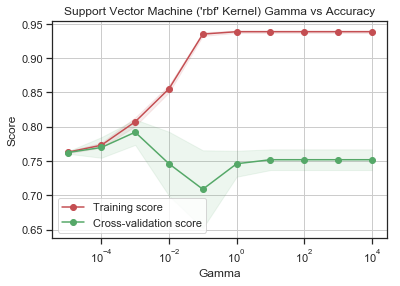

In [68]:
clf = SVC(kernel='rbf', C=100)
plot_validation_curve(estimator=clf,
                      title="Support Vector Machine ('rbf' Kernel) Gamma vs Accuracy",
                      X=X_train, y=y_train, param_name='gamma',
                      param_range=[10**x for x in range(-5, 5)], cv=10,
                      xlab="Gamma", log=True)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=31).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=61).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=91).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: C

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=181).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=211).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=241).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=271).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:2

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=271).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=301).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=331).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=361).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:2

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=331).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=361).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=391).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=421).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:2

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=391).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=421).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=451).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=481).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:2

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

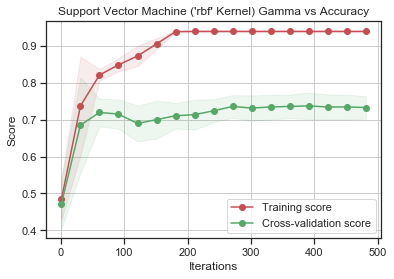

In [67]:
clf = SVC(kernel='rbf', C=100)
plot_validation_curve(estimator=clf,
                      title="Support Vector Machine ('rbf' Kernel) Gamma vs Accuracy",
                      X=X_train, y=y_train, param_name='max_iter',
                      param_range=range(1, 500, 30), cv=10,
                      xlab="Iterations")

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

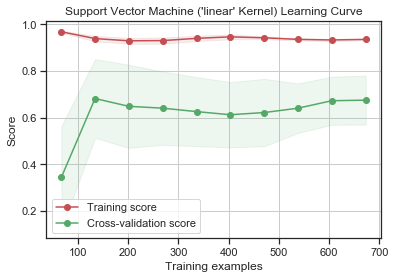

In [70]:
clf = SVC(kernel='rbf', C=100)
plot_learning_curve(estimator=clf,
                    title="Support Vector Machine ('rbf' Kernel) Learning Curve",
                    X=X, y=y, cv=10)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

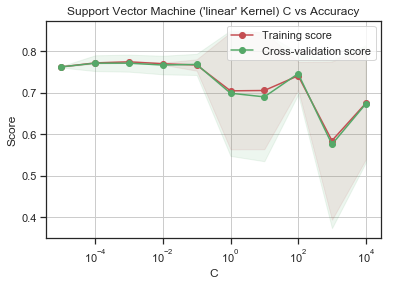

In [84]:
clf = LinearSVC()
plot_validation_curve(estimator=clf,
                      title="Support Vector Machine ('linear' Kernel) C vs Accuracy",
                      X=X_train, y=y_train, param_name='C',
                      param_range=[10**x for x in range(-5, 5)], cv=10,
                      xlab="C", log=True)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

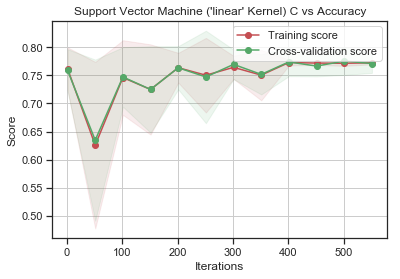

In [80]:
clf = LinearSVC(C=0.1)
plot_validation_curve(estimator=clf,
                      title="Support Vector Machine ('linear' Kernel) C vs Accuracy",
                      X=X_train, y=y_train, param_name='max_iter',
                      param_range=range(1, 600, 50), cv=10,
                      xlab="Iterations")

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

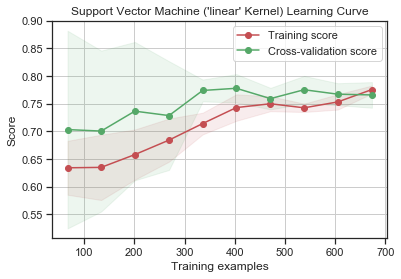

In [82]:
clf = LinearSVC(C=0.1)
plot_learning_curve(estimator=clf,
                    title="Support Vector Machine ('linear' Kernel) Learning Curve",
                    X=X, y=y, cv=10)

# Adult Data Set

In [85]:
adult_data = pd.read_csv('adult.csv')
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [86]:
subsampled_adult_data = adult_data.sample(n=6000, random_state=42)
len(subsampled_adult_data)

6000

In [87]:
dummified_data = pd.get_dummies(subsampled_adult_data,
                                columns=["workclass", "education", "marital_status",
                                         "occupation", "relationship", "race", "sex",
                                         "native_country"])

dummified_data.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
14160,27,160178,10,0,0,38,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
27048,45,50567,9,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28868,29,185908,13,0,0,55,>50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5667,30,190040,13,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7827,29,189346,10,2202,0,50,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [88]:
y = dummified_data["income"]
X = dummified_data.drop(["income"], axis=1)

In [89]:
y_train, y_test = train_test_split(y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.2, stratify=y, random_state=42)

## Using a Decision Tree Classifier